In [52]:
from comet_ml import API
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from collections import defaultdict

api = API()

experiments = api.get_experiments("ai2", "dirkish-ladder")
experiments = [e for e in experiments if not e.archived]

In [53]:
import re
def natural_sort_key(s, _nsre=re.compile(r'(\d+)')):
    return [int(text) if text.isdigit() else text.lower() for text in _nsre.split(s)]

In [54]:
selected_names = set()

for experiment in experiments:
    name, size, duration = experiment.name.rsplit("-", maxsplit=2)
    selected_names.add(name)

print(selected_names)

{'localbaseline', 'baseline', 'baseline2', 'baseline3', 'baseline-titan'}


In [55]:
selected_names = {'baseline3', 'baseline-titan'}

In [56]:
from typing import *

def bar_chart_table(metrics: Set[str], title: Optional[str] = None):
    if title is None and len(metrics) == 1:
        title = list(metrics)[0]

    current_steps = {}
    data_points = []
    for experiment in experiments:
        name, size, length = experiment.name.rsplit("-", maxsplit=2)
        if name not in selected_names:
            continue
        values = []
        steps = set()
        for metric in metrics:
            summary = experiment.get_metrics_summary(metric)
            if len(summary) > 0:
                values.append(float(summary['valueCurrent']))
                steps.add(int(summary['currentStep']))
        if len(values) == len(metrics) and len(steps) == 1:
            current_step = list(steps)[0]
            current_step_key = (name, size, length)
            if current_steps.get(current_step_key, -1) < current_step:
                data_points.append((name, size, length, sum(values) / len(values)))
                current_steps[current_step_key] = current_step

    sizes = {size for _, size, _, _ in data_points}
    lengths = {length for _, _, length, _ in data_points}
    names = {name for name, _, _, _ in data_points}

    sizes = list(sizes)
    sizes.sort(key=natural_sort_key)
    lengths = list(lengths)
    lengths.sort(key=natural_sort_key)

    new_data_points = defaultdict(dict)
    for name, size, length, value in data_points:
        new_data_points[(size, length)][name] = value
    data_points = new_data_points
    del new_data_points

    values = [value for values in data_points.values() for value in values.values()]
    min_value = min(values)
    max_value = max(values)
    if min_value == max_value:
        min_value -= 1
        max_value += 1

    low_color = np.array([0, 1, 0.2], dtype=np.float64)
    mid_color = np.array([0.6, 0.6, 0.6], dtype=np.float64)
    high_color = np.array([1, 0, 0], dtype=np.float64)

    def color_for_value(value):
        value = (value - min_value) / (max_value - min_value)
        if value < 0.5:
            value *= 2
            color = low_color * (1 - value) + (mid_color * value)
        else:
            value -= 0.5
            value *= 2
            color = mid_color * (1 - value) + (high_color * value)
        # lighten
        color += (1 - color) * 0.25
        return tuple(color)

    figure, axs = plt.subplots(
        nrows=len(sizes),
        ncols=len(lengths),
        sharex=True,
        sharey=True,
        squeeze=False
    )

    plt.subplots_adjust(
        left=0.01,    # left margin (default: 0.125)
        right=1 - 0.01,   # right margin (default: 0.9)
        bottom=0.01,  # bottom margin (default: 0.11)
        #top=1 - 0.01,      # top margin (default: 0.88)
        wspace=0,   # width space between subplots (default: 0.2)
        hspace=0    # height space between subplots (default: 0.2)
    )

    for size_idx, size in enumerate(sizes):
        for length_idx, length in enumerate(lengths):
            ax = axs[size_idx][length_idx]
            values = data_points[(size, length)]
            names = list(values.keys())
            names.sort(key=natural_sort_key)
            colors = [
                color_for_value(values[name])
                if name in values else "white"
                for name in names
            ]
            values = [values[name] for name in names]
            bars = ax.barh(names, values, color=colors)
            ax.set_xlim(min_value * 0.95, max_value * 1.05)
            if size_idx == 0:
                ax.set_title(length)
            if length_idx == len(lengths) - 1:
                ax2 = ax.twinx()
                ax2.set_ylabel(size, rotation=0)
                ax2.tick_params(axis='y', which='both', right=False, labelright=False)
            for bar in bars:
                width = bar.get_width()
                ax.text(
                    min_value,
                    bar.get_y() + bar.get_height() / 2,
                    f'{width:.3f}',
                    va='center'
                )

    plt.suptitle(title)

In [57]:
bar_chart_table({"train/CE loss"})
plt.show()

KeyError: 'currentStep'

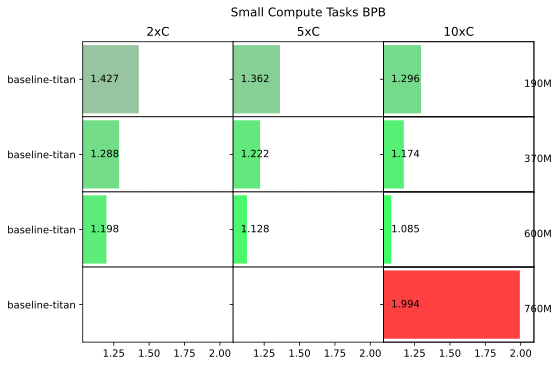

In [50]:
tasks_small_compute = [
    # OLMES Core 9(-ish) RC
    "arc_challenge_test_rc_5shot",
    "arc_easy_test_rc_5shot",
    "hellaswag_rc_5shot", # 1K subset of HellaSwag
    "winogrande_val_rc_5shot", # Helpful after 750M-5xC scale
    "csqa_val_rc_5shot",
    "piqa_val_rc_5shot",
    "socialiqa_val_rc_5shot",

    # Too noisy to be worth tracking
    # "boolq_val_rc_5shot",
    # "openbookqa_test_rc_5shot",

    # MMLU RC
    "mmlu_stem_val_rc_5shot",
    "mmlu_humanities_val_rc_5shot",
    "mmlu_social_sciences_val_rc_5shot",
    "mmlu_other_val_rc_5shot",
    "mmlu_stem_test_rc_5shot",
    "mmlu_humanities_test_rc_5shot",
    "mmlu_social_sciences_test_rc_5shot",
    "mmlu_other_test_rc_5shot",

    # Gen tasks BPB
    "gsm8k_gold_bpb_5shot",
    "minerva_math_algebra_gold_bpb_0shot",
    "minerva_math_counting_and_probability_gold_bpb_0shot",
    "minerva_math_geometry_gold_bpb_0shot",
    "minerva_math_intermediate_algebra_gold_bpb_0shot",
    "minerva_math_number_theory_gold_bpb_0shot",
    "minerva_math_prealgebra_gold_bpb_0shot",
    "minerva_math_precalculus_gold_bpb_0shot",
    "codex_humaneval_gold_bpb_0shot",
    "codex_mbpp_gold_bpb_0shot",

    # Sanity check for MCQA ability
    "copycolors_10way",
]
tasks_small_compute = {f"eval/downstream/{n} (BPB)" for n in tasks_small_compute}

bar_chart_table(tasks_small_compute, "Small Compute Tasks BPB")
plt.show()

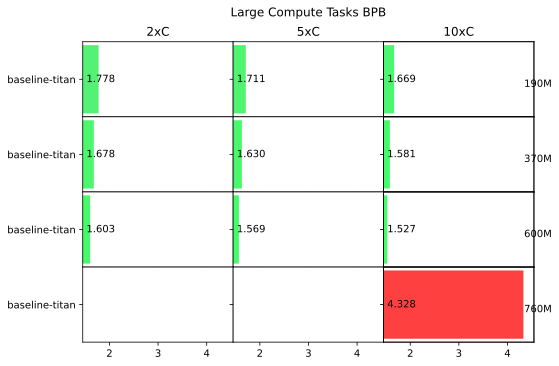

In [51]:
tasks_large_compute = [
    # OLMES Core 9(-ish) MC
    "arc_challenge_test_mc_5shot",
    "arc_easy_test_mc_5shot",
    "hellaswag_rc_5shot", # 1K subset of HellaSwag
    "csqa_val_mc_5shot",
    "piqa_val_mc_5shot",
    "socialiqa_val_mc_5shot",
    "winogrande_val_rc_5shot",

    # Too noisy to be worth tracking
    # "boolq_val_mc_5shot",
    # "openbookqa_test_mc_5shot",

    # MMLU MC BPB
    "mmlu_stem_val_mc_5shot",
    "mmlu_humanities_val_mc_5shot",
    "mmlu_social_sciences_val_mc_5shot",
    "mmlu_other_val_mc_5shot",
    "mmlu_stem_test_mc_5shot",
    "mmlu_humanities_test_mc_5shot",
    "mmlu_social_sciences_test_mc_5shot",
    "mmlu_other_test_mc_5shot",

    # Gen tasks BPB
    "gsm8k_gold_bpb_5shot",
    "minerva_math_algebra_gold_bpb_0shot",
    "minerva_math_counting_and_probability_gold_bpb_0shot",
    "minerva_math_geometry_gold_bpb_0shot",
    "minerva_math_intermediate_algebra_gold_bpb_0shot",
    "minerva_math_number_theory_gold_bpb_0shot",
    "minerva_math_prealgebra_gold_bpb_0shot",
    "minerva_math_precalculus_gold_bpb_0shot",
    "codex_humaneval_gold_bpb_0shot",
    "codex_mbpp_gold_bpb_0shot",

    # Sanity check for MCQA ability
    "copycolors_10way",
]
tasks_large_compute = {f"eval/downstream/{n} (BPB)" for n in tasks_large_compute}

bar_chart_table(tasks_large_compute, "Large Compute Tasks BPB")
plt.show()